<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [1]:
RANDOM_STATE = 42
N_FOLDS = 5

In [2]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [3]:
dataset_files = sorted(glob('../../data/chicago/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [4]:
with open('../../data/chicago/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [5]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [6]:
assert df.shape == (5432105, 18)

In [7]:
df.tips.value_counts(dropna=False)

0.00     2982546
2.00      741442
1.00      243732
3.00      237919
1.50       59880
4.00       58635
5.00       55453
1.25       18573
2.50       18110
10.00      17314
6.00       17278
2.25       14958
8.00       14231
1.75       13200
7.00       12944
2.10       12700
2.05       12594
2.15       10987
2.75       10930
2.55       10876
2.20       10168
3.50       10106
2.40        9927
3.05        9898
2.65        9514
2.60        9472
2.30        9231
2.45        9117
3.25        9004
3.15        8955
          ...   
42.25          1
13.54          1
13.46          1
33.31          1
40.75          1
13.21          1
23.36          1
12.96          1
11.96          1
8.22           1
15.67          1
50.75          1
41.98          1
11.71          1
11.54          1
25.64          1
34.44          1
49.75          1
49.50          1
49.25          1
11.46          1
34.19          1
49.00          1
48.50          1
48.25          1
11.21          1
50.45          1
8.47          

In [8]:
sum(df.tips.isnull())

57

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
taxi_id,5432012.0,4382.167455,2524.008644,0.0,2235.0,4359.0,6598.0,8762.00
trip_seconds,5431184.0,675.580901,925.171047,0.0,300.0,480.0,840.0,86340.00
trip_miles,5432084.0,3.065537,22.541489,0.0,0.0,1.0,2.5,3280.00
pickup_census_tract,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_census_tract,3163439.0,518.448815,357.540683,0.0,225.0,504.0,849.0,1141.00
pickup_community_area,4512556.0,23.488869,19.681299,1.0,8.0,24.0,32.0,77.00
dropoff_community_area,4425344.0,21.388456,17.468606,1.0,8.0,21.0,32.0,77.00
tips,5432048.0,1.588289,2.918154,0.0,0.0,0.0,2.0,496.50
tolls,5432048.0,0.003124,0.510297,0.0,0.0,0.0,0.0,999.99
extras,5432048.0,0.934464,23.017321,0.0,0.0,0.0,1.0,9993.41


**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- tips
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- логарифмирование
- никакие

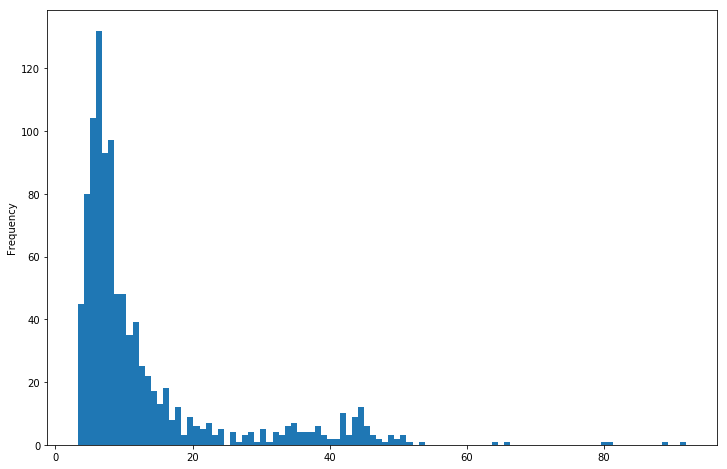

In [7]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- 43.66

In [29]:
from geopy.distance import great_circle
from joblib import Parallel, delayed

In [26]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna().astype(int)

In [39]:
for column in pickup_dropoff.columns:
    print(column)
    pickup_dropoff[column] = pickup_dropoff[column].astype(str).map(column_remapping[column])

pickup_latitude
pickup_longitude
dropoff_latitude
dropoff_longitude


In [41]:
%%time
results = Parallel(n_jobs=6)(delayed(great_circle)(tuple(row[:2]), tuple(row[2:])) for row in pickup_dropoff.values)

Wall time: 0 ns


In [47]:
max(e.km for e in results)

43.662892734777216

Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [22]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE + 2)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE

pipeline0 = make_pipeline(LinearRegression())
print(np.abs(cross_val_score(pipeline0, 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

pipeline1 = make_pipeline(StandardScaler(),
                         LinearRegression())
print(np.abs(cross_val_score(pipeline1, 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

pipeline2 = make_pipeline(MinMaxScaler(),
                         LinearRegression())
print(np.abs(cross_val_score(pipeline2, 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

945.273458615
945.273458615
945.273458615
Wall time: 17.5 s


In [15]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

914.418443144
Wall time: 4.58 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- не зафиксирован random seed
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

for f in ['', 'tips', 'tolls', 'trip_seconds', 'trip_miles']:
    features = [e for e in X_data.columns if e != f]
    pipeline = make_pipeline(StandardScaler(),
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print(f, 
    np.abs(cross_val_score(pipeline,
                    X=X_data[features].values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())
    )

 877.711818186
tips 908.722836036
tolls 719.773903068
trip_seconds 905.274108233
trip_miles 879.313958264


**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- tolls 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [111]:
%%time
#with warnings.catch_warnings():
#warnings.simplefilter("ignore")
X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles', 'tips']].reset_index(drop=True)
X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
mask = np.isnan(target.reset_index(drop=True))

X_data = X_data[~mask]#.reset_index(drop=True)
y_data = target.reset_index(drop=True)[~mask]#.reset_index(drop=True)

Wall time: 803 ms


In [72]:
X_data.shape, y_data.shape, mask.shape, target.shape, sum(target.isnull()), sum(np.isnan(y_data))

((5432048, 3), (5432048,), (5432105,), (5432105,), 57, 0)

In [112]:
tt = X_data['trip_start_timestamp']

In [113]:
timestamp = pd.to_datetime(tt)

In [114]:
timestamp

0         2016-01-13 06:15:00
1         2016-01-22 09:30:00
2         2016-01-31 21:30:00
3         2016-01-23 17:30:00
4         2016-01-14 05:45:00
5         2016-01-08 18:15:00
6         2016-01-14 04:30:00
7         2016-01-26 04:15:00
8         2016-01-22 11:30:00
9         2016-01-07 21:15:00
10        2016-01-25 09:00:00
11        2016-01-06 23:15:00
12        2016-01-13 18:30:00
13        2016-01-22 09:45:00
14        2016-01-03 07:45:00
15        2016-01-03 16:30:00
16        2016-01-25 10:30:00
17        2016-01-29 08:15:00
18        2016-01-11 14:00:00
19        2016-01-01 19:30:00
20        2016-01-20 07:30:00
21        2016-01-08 19:30:00
22        2016-01-02 13:30:00
23        2016-01-15 19:30:00
24        2016-01-19 11:15:00
25        2016-01-14 14:15:00
26        2016-01-23 21:45:00
27        2016-01-17 21:00:00
28        2016-01-23 21:00:00
29        2016-01-17 01:00:00
                  ...        
5432075   2016-03-12 19:00:00
5432076   2016-03-15 11:00:00
5432077   

In [74]:
%%time
t1 = timestamp.apply(lambda x: x.dayofweek)

Wall time: 12.4 s


In [75]:
%%time
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 36.7 s


In [106]:
X_data_changed = X_data.copy()
X_data_changed['time'] = t1

In [107]:
pd.concat([X_data_changed[['time']], y_data], axis = 1).groupby('time').agg(np.mean)

,fare
time,
0,14.648235
1,13.498443
2,13.385018
3,13.630986
4,12.880889
5,11.970498
6,14.059370


In [115]:
for i, t in enumerate((None, t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    # Ваш код здесь
    if i != 0:
        X_data_changed['time'] = t#.reset_index(drop=True)
        X_data_changed['time'] = tt.apply(lambda x: x.split(' ')[1].split(':')[0]).astype(int)
        features = ['trip_seconds', 'trip_miles', 'time']
    else:
        features = ['trip_seconds', 'trip_miles']
    pipeline = make_pipeline(StandardScaler(),
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print(i, features,
    np.abs(cross_val_score(pipeline,
                    X=X_data_changed[features].values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())
    )
    if i == 1:
        break

0 ['trip_seconds', 'trip_miles'] 748.904565345
1 ['trip_seconds', 'trip_miles', 'time'] 748.904920723


In [77]:
X_data_changed

,trip_seconds,trip_miles,time
0,180.0,0.40,54
1,240.0,0.70,105
2,0.0,0.00,165
3,480.0,1.10,137
4,480.0,2.71,77
5,1080.0,6.20,114
6,1500.0,18.40,76
7,60.0,0.20,28
8,180.0,0.00,107
9,0.0,0.00,93


** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- новые признаки не улучшают модель, т.к. такова природа данных
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

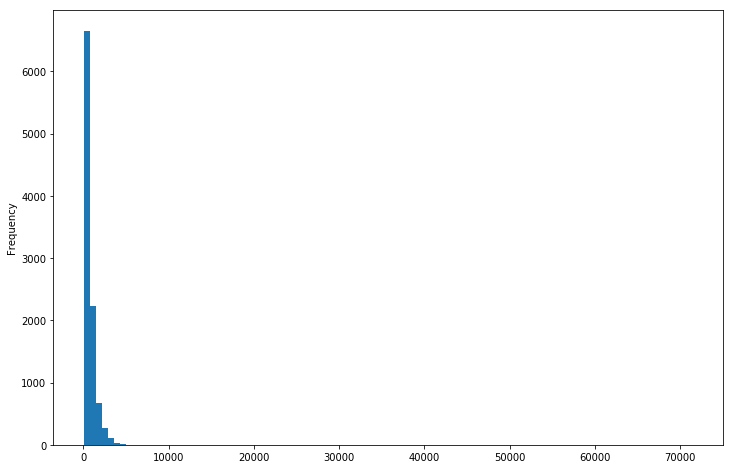

In [80]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

In [89]:
seconds.min()

60.0

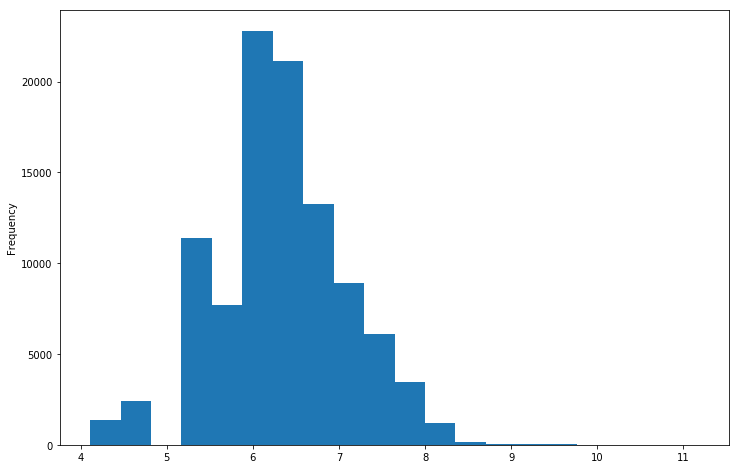

In [85]:
seconds.sample(100000).apply(lambda x: 
                            np.log(x + 1)).plot(kind='hist', bins=20);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- чтобы запутать читателей
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`